In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import driver
import robo_supply_model

In [3]:
foundation_breakdown = {
    'ecosystem': 100_000_000,
    'community_infra': 50_000_000,
    'fundraising': 77_000_000,
    'investments': 30_000_000,
    'research': 50_000_000,
}
# of these categories, ecosystem, community_infra, investments, and research are considered
# to be part of the community supply.
# so when we compute the percentage of the total supply for each emission type, we need to
# we take this into acocunt.  since the foundation is vested, 
# we assume all of these components vest at the same rate so we compute percentages.
foundation_to_community_pct = (
    foundation_breakdown['ecosystem'] + 
    foundation_breakdown['community_infra'] + 
    foundation_breakdown['investments'] + 
    foundation_breakdown['research']
) / sum(foundation_breakdown.values())
foundation_remaining_pct = 1 - foundation_to_community_pct


In [4]:
emissions_start = 5_000_000
emissions_end = 500_000
emissions_total_target = 207_000_000
# emissions_total_target = 125_000_000
subnet_maintenance_fee_pct = 0.20

In [5]:
airdrop_vest = 6
community_vest = 12

In [6]:
df_baseline = driver.sim2(
    ent_arrival_rate=100.0,  # average new entities per month
    ent_lifetime_months=24,  # entities depart after this many months
    subnet_lifetime_months=36,  # subnets depart after this many months
    initial_subnet_revenue=0,  # $100k initial revenue per subnet per month
    max_subnet_revenue=100000,  # $1M max revenue per subnet per month
    revenue_growth_months=48,  # months to reach max revenue
    revenue_burn_pct=0.5,  
    initial_token_price=0.30,  # $0.30 initial token price
    annual_price_growth_rate=0.0,  # 1% annual growth rate
    initial_target_staking_apy=0.08,  # 8% initial target staking APY
    final_target_staking_apy=0.04,  # 4% final target staking APY
    staking_apy_transition_months=48,  # months to transition from initial to final APY
    linear_start_emission=emissions_start,
    linear_end_emission=emissions_end,
    linear_total_emissions=emissions_total_target,
    dynamic_staking_fees=False,
    airdrop_allocation=50_000_000,  # 50M airdrop allocation
    community_round_allocation=23_000_000,  # 23M community round allocation
    airdrop_vesting_months=airdrop_vest, 
    community_round_vesting_months=community_vest,
    subnet_maintenance_fee_pct=subnet_maintenance_fee_pct,
)

7840909.090909091 784090.9090909091


In [7]:
(784090.9090909091-7840909.090909091)/47

-150145.0676982592

In [8]:
4/47

0.0851063829787234

249483276.0226186


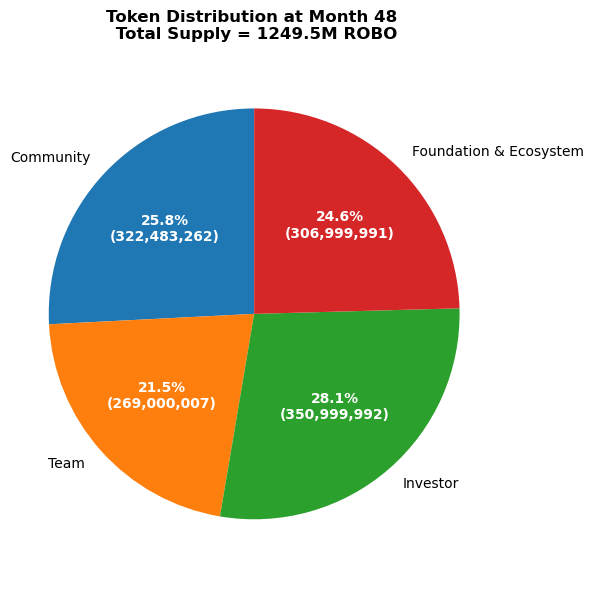

In [9]:
dff = df_baseline
mo = 48
community = dff['cumulative_emissions'].iloc[mo] + dff['airdrop_released'].iloc[mo] + dff['community_round_released'].iloc[mo]
team = dff['team_vested'].iloc[mo]
investor = dff['investor_vested'].iloc[mo]
foundation = dff['foundation_vested'].iloc[mo]
total= community + team + investor + foundation
# make a pie chart of this at month 48
# Create the pie chart
fig, ax = plt.subplots(figsize=(6, 6))
labels = ['Community', 'Team', 'Investor', 'Foundation & Ecosystem']
sizes = [community, team, investor, foundation]
# colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:,})'
    return my_autopct

# Create the pie chart
wedges, texts, autotexts = ax.pie(sizes, labels=labels,
                                   autopct=make_autopct(sizes), startangle=90)

# Customize the text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Add title
emissions_total_48 = dff['cumulative_emissions'].iloc[mo]
print(emissions_total_48)

# ax.set_title(f'Token Distribution at Month {mo}: Total Supply = {total/1e6:.1f}M \n (Rewards + Staking Emissions + Airdrop + Community Round) = {emissions_total_48/1e6:.1f}M', fontweight='bold')
ax.set_title(f'Token Distribution at Month {mo} \n Total Supply = {total/1e6:.1f}M ROBO', fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

plt.tight_layout()
plt.savefig('supply_mo48.png')

In [10]:
def plot_simulation(df, foundation_remaining_pct=0.5, foundation_to_community_pct=0.5):
    """
    Plot comparison of multiple simulation runs.
    
    Parameters:
    -----------
    dataframes_dict : dict
        Dictionary where keys are configuration labels (strings) and values are dataframes
        Example: {"Config A": df1, "Config B": df2, "Conservative": df3}
    foundation_remaining_pct : float
        Percentage of foundation tokens remaining (default 0.5)
    foundation_to_community_pct : float  
        Percentage of foundation tokens going to community (default 0.5)
    """
    
    # Create color map for different configurations
    cmap = plt.cm.get_cmap('tab10')
    colors = cmap.colors
    
    fig, ax = plt.subplots(figsize=(10, 7), nrows=2, ncols=3)
    
    # Plot 1: Community Portion of Supply
    axx = ax[0, 0]
    total_supply = df['team_vested'] + df['investor_vested'] + df['foundation_vested'] + df['cumulative_emissions']
    foundation_actual = df['foundation_vested'] * foundation_remaining_pct
    foundation_to_community = df['foundation_vested'] * foundation_to_community_pct
    community_pct = (df['cumulative_emissions'] + foundation_to_community) / total_supply
    axx.plot(df['month'], df['team_vested']/1e6, label='Team')
    axx.plot(df['month'], df['investor_vested']/1e6, label='Investor')
    axx.plot(df['month'], df['foundation_vested']/1e6, label='Foundation & Ecosystem')
    axx.plot(df['month'], df['cumulative_emissions']/1e6, label='Community')
    axx.legend(fontsize=7)
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('M-ROBO')
    axx.set_title('Supply Components')
    
    # Plot 2: Circulating Supply
    axx = ax[0, 1]
    axx.plot(df['month'], df['circulating_supply']/1e6, label='Circulating Supply')
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_title('Circulating Supply')
    # axx.legend()
    
    # Plot 4: Locked/Circulating Percentage
    axx = ax[0, 2]
    axx.plot(df['month'], df['total_locked_supply']/df['circulating_supply']*100, label='Locked/Circulating Pct.')
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('%')
    axx.set_title('Locked/Circulating Pct.')
    

    # Plot 5: Inflation Rate
    axx = ax[1, 0]
    axx.plot(df['month'], df['total_emissions']/df['circulating_supply'].shift(1)*100, label='Monthly Inflation Rate')
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('%')
    axx.set_title('Monthly Inflation Rate')
    # axx.legend()

    # Plot 6: Burn/Emissions Percentage
    axx = ax[1, 1]
    axx.plot(df['month'], df['cumulative_burn']/df['cumulative_emissions']*100, label='Burn/Emissions Pct.')
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('%')
    axx.set_title('Burn/Emissions Pct.')
    
    # Plot 7: Subnet Reward Emissions
    axx = ax[1, 2]
    axx.plot(df['month'], df['base_emissions']/1e6, label='Subnet Reward Emissions')
    axx.axvline(x=48, color='black', linestyle='--', linewidth=0.5)
    axx.set_xlabel('Month')
    axx.set_ylabel('M-ROBO')
    axx.set_title('Subnet Reward Emissions')
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_621299/4277906536.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


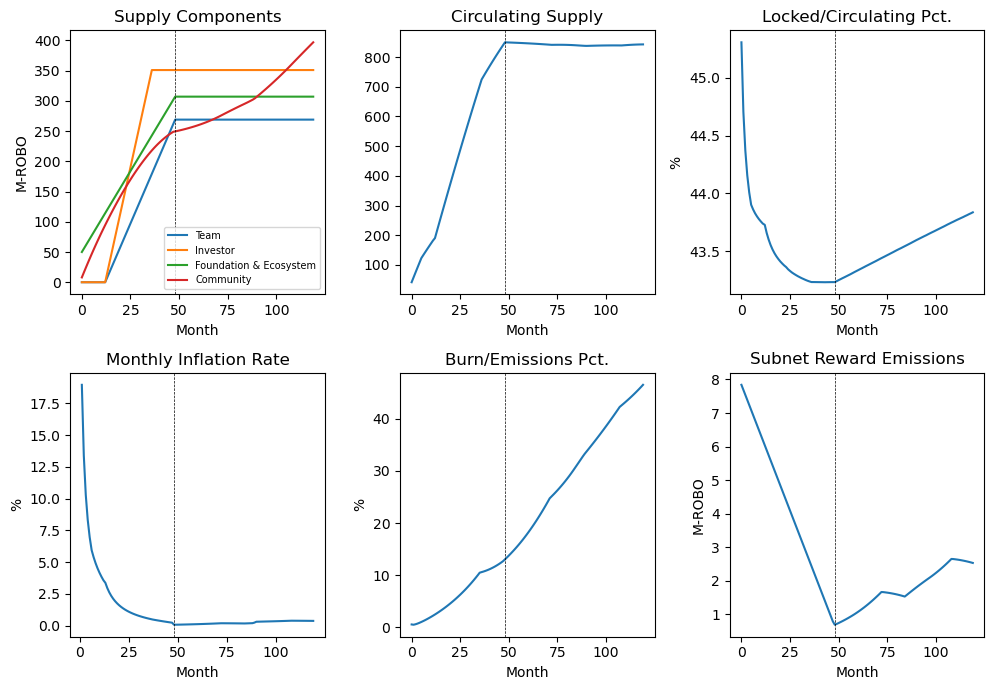

In [11]:
plot_simulation(df_baseline)

In [12]:
df_copy = robo_supply_model.print_yearly_emissions_percentage(df_baseline)

Emissions as % of Total Supply by Year:
Year 1: 88,034,112 ROBO / 1,000,000,000 ROBO = 8.80%
Year 2: 71,403,025 ROBO / 1,071,403,025 ROBO = 6.66%
Year 3: 54,798,491 ROBO / 1,126,201,516 ROBO = 4.87%
Year 4: 34,564,588 ROBO / 1,160,766,103 ROBO = 2.98%
Year 5: 10,138,101 ROBO / 1,170,904,204 ROBO = 0.87%
Year 6: 15,852,099 ROBO / 1,186,756,303 ROBO = 1.34%
Year 7: 19,321,082 ROBO / 1,206,077,386 ROBO = 1.60%
Year 8: 26,577,513 ROBO / 1,232,654,899 ROBO = 2.16%
Year 9: 36,739,617 ROBO / 1,269,394,516 ROBO = 2.89%
Year 10: 39,431,482 ROBO / 1,308,825,998 ROBO = 3.01%


In [13]:
# sanity check the community emissions
df_copy['emissions_noairdropcommunity'] = df_copy['total_emissions'] + df_copy['airdrop_monthly_release'] + df_copy['community_round_monthly_release']
yearly_emissions = df_copy.groupby('year')['emissions_noairdropcommunity'].sum()
yearly_emissions

year
1     1.610341e+08
2     7.140302e+07
3     5.479849e+07
4     3.456459e+07
5     1.013810e+07
6     1.585210e+07
7     1.932108e+07
8     2.657751e+07
9     3.673962e+07
10    3.943148e+07
Name: emissions_noairdropcommunity, dtype: float64

In [14]:
robo_supply_model.print_yearly_subnet_rewards(df_baseline)

Total Subnet Rewards by Year:
Year 1: 84,181,335 ROBO (84.18M ROBO)
Year 2: 62,560,445 ROBO (62.56M ROBO)
Year 3: 40,939,555 ROBO (40.94M ROBO)
Year 4: 19,318,665 ROBO (19.32M ROBO)
Year 5: 10,138,101 ROBO (10.14M ROBO)
Year 6: 15,852,099 ROBO (15.85M ROBO)
Year 7: 19,321,082 ROBO (19.32M ROBO)
Year 8: 21,276,769 ROBO (21.28M ROBO)
Year 9: 27,690,999 ROBO (27.69M ROBO)
Year 10: 31,155,977 ROBO (31.16M ROBO)

Total Subnet Rewards by Year (USD):
Year 1: $25,254,400 (avg price: $0.30)
Year 2: $18,768,133 (avg price: $0.30)
Year 3: $12,281,867 (avg price: $0.30)
Year 4: $5,795,600 (avg price: $0.30)
Year 5: $3,041,430 (avg price: $0.30)
Year 6: $4,755,630 (avg price: $0.30)
Year 7: $5,796,325 (avg price: $0.30)
Year 8: $6,383,031 (avg price: $0.30)
Year 9: $8,307,300 (avg price: $0.30)
Year 10: $9,346,793 (avg price: $0.30)

Average Per-Subnet Rewards by Year:
Year 1: 9,915,838 ROBO ($2,974,751) per subnet (avg 8.5 subnets)
Year 2: 5,329,017 ROBO ($1,598,705) per subnet (avg 11.7 subnets)


year
1     8.418133e+07
2     6.256044e+07
3     4.093956e+07
4     1.931867e+07
5     1.013810e+07
6     1.585210e+07
7     1.932108e+07
8     2.127677e+07
9     2.769100e+07
10    3.115598e+07
Name: base_emissions, dtype: float64

In [15]:
df_baseline.columns

Index(['month', 'team_vested', 'investor_vested', 'foundation_vested',
       'airdrop_released', 'community_round_released',
       'airdrop_monthly_release', 'community_round_monthly_release',
       'base_emissions', 'additional_staking_emissions', 'total_emissions',
       'burn', 'circulating_supply', 'total_locked_supply', 'staking_supply',
       'ent_collateral', 'subnet_collateral', 'staking_rewards',
       'subnet_rewards', 'staking_apy', 'target_staking_budget',
       'actual_staking_budget', 'subnet_guaranteed_emissions',
       'ent_registration_fees', 'subnet_registration_fees',
       'subnet_maintenance_fees', 'total_fees', 'active_ents',
       'active_subnets', 'total_collateral', 'new_ents', 'new_subnets',
       'ent_departures', 'subnet_departures', 'cumulative_emissions',
       'cumulative_burn', 'cumulative_fixed_emissions', 'cumulative_fees',
       'ent_registration_fee', 'subnet_registration_fee',
       'ent_collateral_amount', 'subnet_collateral_amount',


In [16]:
df_baseline[['month','base_emissions']].to_csv('base_emissions.csv', index=False)

In [17]:
df_baseline[['month','total_emissions']].to_csv('total_emissions.csv', index=False)